## Model comparison plot

Show predictions vs truth for a range of our different models

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import os
from cancernet import PnetDataSet, ReactomeNetwork
import torch, torch_geometric.transforms as T, torch.nn.functional as F
from cancernet.dataset import get_layer_maps
from torch_geometric.loader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
from cancernet.util import ProgressBar, InMemoryLogger, get_roc


from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import time
import pytorch_lightning as pl


import torch
from torch import nn

from sklearn.linear_model import LogisticRegression
from cancernet.arch import BaseNet, GATNet, PNet, VgnNet, InteractionNet

/mnt/home/cpedersen/miniconda3/envs/cancerenv_tib/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/mnt/home/cpedersen/miniconda3/envs/cancerenv_tib/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
reactome_kws = dict(
    reactome_base_dir=os.path.join("/mnt/home/cpedersen/ceph/Data/data", "reactome"),
    relations_file_name="ReactomePathwaysRelation.txt",
    pathway_names_file_name="ReactomePathways.txt",
    pathway_genes_file_name="ReactomePathways.gmt",
)
reactome = ReactomeNetwork(reactome_kws)

prostate_root = os.path.join("/mnt/home/cpedersen/ceph/Data/data", "prostate")
dataset = PnetDataSet(
    root=prostate_root,
    name="prostate_graph_humanbase",
    edge_tol=0.5,
    pre_transform=T.Compose(
        [T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]
    ),
)

# loads the train/valid/test split from pnet
splits_root = os.path.join(prostate_root, "splits")
dataset.split_index_by_file(
    train_fp=os.path.join(splits_root, "training_set_0.csv"),
    valid_fp=os.path.join(splits_root, "validation_set.csv"),
    test_fp=os.path.join(splits_root, "test_set.csv"),
)

maps = get_layer_maps(
    genes=[g for g in dataset.node_index],
    reactome=reactome,
    n_levels=2,
    direction="root_to_leaf",
    add_unk_genes=False,
    verbose=True,
)

train_loader = DataLoader(
    dataset,
    batch_size=10,
    sampler=SubsetRandomSampler(dataset.train_idx),
    num_workers=10
)

valid_loader = DataLoader(
    dataset,
    batch_size=10,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    num_workers=10
)

test_loader = DataLoader(
    dataset,
    batch_size=10,
    sampler=SequentialSampler(dataset.test_idx),
    num_workers=10,
)

layer # 0
pathways 146
genes 10621
filtered_map (9054, 0)
filtered_map (9054, 0)
filtered_map (9054, 0)
layer # 1
pathways 26
genes 147
filtered_map (146, 0)
filtered_map (146, 0)
filtered_map (146, 0)
layer # 2
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)


In [3]:
def get_numpy_values(test_loader):
    """ Iterate over a test loader, concat into numpy arrays for LR performance estimation """
    numpy_y=np.array([])

    for data in test_loader:
        numpy_y=np.append(numpy_y,data.y)
        batch_x=torch.reshape(data.x,(int(data.x.shape[0]/9054),9054*3)).numpy()
        try:
            numpy_x=np.vstack((numpy_x,batch_x))
        except:
            numpy_x=batch_x
    return numpy_x, numpy_y

def log_reg(dataset,test_loader,mut_only=False):
    """ Run logistic regression """
    ## Train
    true_numpy=dataset.data.y.numpy()
    if mut_only:
        ## Take only the mutations
        reshaped=torch.reshape(dataset.data.x[:,0],(1011,9054)).numpy()
    else:
        ## Include copy number variations
        reshaped=torch.reshape(dataset.data.x,(1011,9054*3)).numpy()
    clf = LogisticRegression(random_state=0).fit(reshaped[dataset.train_idx], true_numpy[dataset.train_idx])
    return clf

def train_model(model,train_loader,valid_loader):
    logger = InMemoryLogger()
    early_stop_callback = EarlyStopping(
        monitor="val_loss", min_delta=0.00, patience=50, verbose=False, mode="min"
    )

    # XXX this cannot be fully deterministic on GPU because
    # XXX scatter_add_cuda_kernel does not have a deterministic implementation!
    trainer = pl.Trainer(
        accelerator="auto",
        max_epochs=n_epochs,
        callbacks=[ProgressBar(), early_stop_callback],
        logger=logger,
        # deterministic=True,
    )
    t0 = time.time()
    trainer.fit(model, train_loader,valid_loader)
    return model

In [4]:
# try to ensure reproducibility
pl.seed_everything(42, workers=True)

n_epochs = 100
batch_size = 10
lr = 0.01

Global seed set to 42


In [5]:
model_LR=log_reg(dataset,test_loader)
#print("LR accuracy =",np.sum((pred_LR>0.5)==true_LR)/len(pred_LR))

In [6]:
model_gat = GATNet(dims=[3, 64, 256, 128], lr=lr)
model_gat=train_model(model_gat,train_loader,valid_loader)

/mnt/home/cpedersen/miniconda3/envs/cancerenv_tib/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/mnt/home/cpedersen/miniconda3/envs/cancerenv_tib/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.LightningLoggerBase` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.Logger` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [7]:
model_vgcn = VgnNet(dims=[3, 64, 256], lr=lr, layers=maps[:-1])
model_vgcn = train_model(model_vgcn,train_loader,valid_loader)

/mnt/home/cpedersen/miniconda3/envs/cancerenv_tib/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/mnt/home/cpedersen/miniconda3/envs/cancerenv_tib/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.LightningLoggerBase` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.Logger` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name

Training:   0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
model_pnet = PNet(
    layers=maps,
    num_genes=maps[0].shape[0], # 9054
    lr=lr
)

model_pnet=train_model(model_pnet,train_loader,valid_loader)

/mnt/home/cpedersen/miniconda3/envs/cancerenv_tib/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/mnt/home/cpedersen/miniconda3/envs/cancerenv_tib/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.LightningLoggerBase` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.Logger` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [9]:
model_pnet.eval()
model_vgcn.eval()
model_gat.eval()

true=np.array([])
pred_pnet=np.array([])
pred_vgcn=np.array([])
pred_gat=np.array([])

## Delete LR_x if it exists
try:
    del LR_x
except:
    pass

for data in test_loader:
    ## Iterate over test loader for all models at once, to ensure we have the same ordering
    true=np.append(true,data.y)
    pred_pnet=np.append(pred_pnet,model_pnet(data).detach().numpy()) ## Pnet uses BCE loss
    pred_vgcn=np.append(pred_vgcn,np.exp(model_vgcn(data)[:,1].detach().numpy())) ## Graph models use log loss, so we exponentiate
    pred_gat=np.append(pred_gat,np.exp(model_gat(data)[:,1].detach().numpy()))
    ## Batch values for LR, done at the end
    batch_x=torch.reshape(data.x,(int(data.x.shape[0]/9054),9054*3)).numpy()
    try:
        LR_x=np.vstack((LR_x,batch_x))
    except:
        LR_x=batch_x
        
pred_LR=model_LR.predict_proba(LR_x)[:,1]

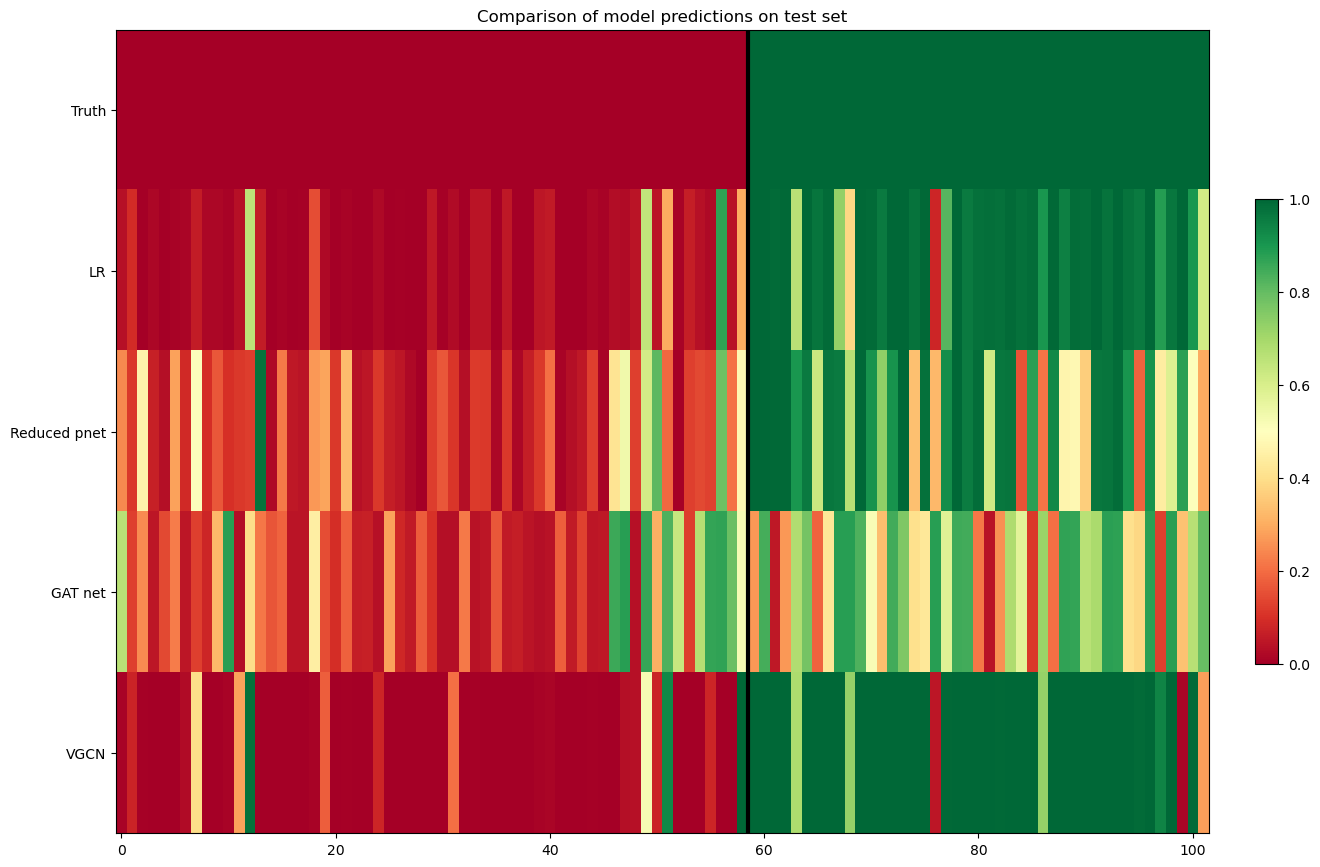

In [10]:
ys=[0,1,2,3,4]
labels=["Truth","LR","Reduced pnet","GAT net","VGCN"]


plt.figure(figsize=(15,32))
plt.title("Comparison of model predictions on test set")
plt.imshow(np.vstack((true[np.argsort(true)],pred_LR[np.argsort(true)],pred_pnet[np.argsort(true)],pred_gat[np.argsort(true)],pred_vgcn[np.argsort(true)])),aspect=15,interpolation="none",cmap="RdYlGn")
plt.axvline(np.argmax(true[np.argsort(true)])-0.5,color="black",linewidth=3) ## Solid black line just to differentiate between 0 and 1 test points
plt.colorbar(fraction=0.02, pad=0.04)
plt.yticks(ys,labels);